In [1]:
%matplotlib inline

In [2]:
path = "data/dogscats/sample/"

In [3]:
from __future__ import division, print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

In [7]:
import utils; reload(utils)

<module 'utils' from 'utils.pyc'>

In [8]:
from utils import plots

In [9]:
batch_size=16

In [11]:
import vgg16; reload(vgg16)
from vgg16 import Vgg16

In [23]:
vgg = Vgg16()
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)
vgg.finetune(batches)
vgg.fit(batches, val_batches, nb_epoch=2)

Found 16 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Epoch 1/2
16/16 [==============================] - 10s - loss: 1.3252 - acc: 0.4375 - val_loss: 1.2990 - val_acc: 0.6250
Epoch 2/2
16/16 [==============================] - 10s - loss: 0.9606 - acc: 0.6875 - val_loss: 1.2303 - val_acc: 0.7500


# Creating VGG model from scratch

In [28]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

In [29]:
FILES_PATH = 'http://files.fast.ai/models'
CLASS_FILE = 'imagenet_class_index.json'
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
with open(fpath) as f:
    class_dict= json.load(f)
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [31]:
classes[:5]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']

In [38]:
def ConvBlock(layers, model, filters):
    for i in range(layers):
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

In [39]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

In [40]:
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean  # subtract mean
    return x[:, ::-1]  # reverse exis bgr->rgb

In [41]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,244,244)))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)
    
    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

In [42]:
model = VGG_16()

/Users/zupo/anaconda/lib/python2.7/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_7 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 244, 244)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [43]:
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

In [44]:
batch_size=4

In [45]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True,
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(244,244),
        class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [46]:
batches = get_batches('train', batch_size=batch_size)

Found 16 images belonging to 2 classes.


In [48]:
val_batches = get_batches('valid', batch_size=batch_size)

Found 8 images belonging to 2 classes.


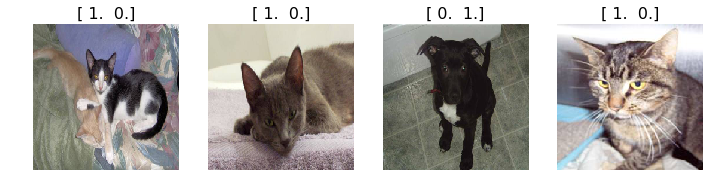

In [50]:
imgs,labels = next(batches)
plots(imgs, titles=labels)

In [51]:
def pred_batch(imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)
    
    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(classes[:5]))
    print('First 5 probabilities: {}\n'.format(preds[0, :5]))
    print('Predictions prob/classes: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('    {:.4f}/{}'.format(preds[i, idx], classes[idx]))

In [52]:
pred_batch(imgs)

Shape: (4, 1000)
First 5 classes: [u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']
First 5 probabilities: [  1.9856e-05   3.1538e-05   1.5066e-04   1.4755e-04   1.2129e-04]

Predictions prob/classes: 
    0.2786/toy_terrier
    0.6573/Egyptian_cat
    0.0681/Staffordshire_bullterrier
    0.7110/tabby
